## This notebook analyzes data for pricing optimization from an A/B test targeting conversion rates for an app. 

### Three main questions are addressed:
1) At which price should the company list their software? <br>
2) What attributes of customer behavior influence conversion rate? <br>
3) How long should the experiment have taken? <br>

### The results are summarized below:
1) The company had a higher conversion rate for lower priced software. However, the difference in conversion rates did not outweigh the revenue generated by the higher priced software. Therefore, the company should list their software at a higher price.<br>
<br>
2) The top three sources of the highest conversion rates were: 1) Friend Referral,  2) Seo-bing, 3) Ads-google. The company could invest more in these domains given that they work and eliminate sources with low conversion rates, or rethink the strategy for sources with low conversion rates. In addition, windows and android users are less likely to convert, and a targeted marketing approach should be implemented towards these groups. <br>
<br>
3) Based on a power analysis, the experiment could have been conducted in 5 days with 34,578 users. However, I would recommend 2 weeks due to variations in user activity based on day of the week.

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
# read in data
test_results = pd.read_csv("data/test_results.csv")
user_table = pd.read_csv("data/user_table.csv")

### Check data for any abnormalities or missing values

In [3]:
# inspect the test data
test_results = test_results.drop("Unnamed: 0", axis=1)
test_results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0


In [4]:
# inspect the users table
user_table.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [5]:
# inspect data types for test results
print("Entries in test results table:", test_results.shape[0])
print("")
test_results.info()

Entries in test results table: 316800

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
user_id             316800 non-null int64
timestamp           316466 non-null object
source              316488 non-null object
device              316800 non-null object
operative_system    296461 non-null object
test                316800 non-null int64
price               316800 non-null float64
converted           316800 non-null int64
dtypes: float64(1), int64(3), object(4)
memory usage: 19.3+ MB


316800 total entries. There are missing values for the timestamp, source, and operative system variables.

In [6]:
# number of null values
print("timestamp null values is", test_results.timestamp.isnull().sum())
print("source null values is", test_results.source.isnull().sum())
print("OS null values is", test_results.operative_system.isnull().sum())

timestamp null values is 334
source null values is 312
OS null values is 20339


In [7]:
# inspect data types for user table
print("Entries in user table:", user_table.shape[0])
print("")
user_table.info()

Entries in user table: 275616

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
user_id    275616 non-null int64
city       275616 non-null object
country    275616 non-null object
lat        275616 non-null float64
long       275616 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


All data are present for the user table, but there is a mismatch between the number of <br>
users in this table and the number of users in test results. More users in the test <br>
results table.

In [8]:
# are there duplicate users in the test results table? --- No, just more users 
print("Number of unique user ids is:", test_results.user_id.nunique())

Number of unique user ids is: 316800


There are more users in the test results table than in the users table, and all users in the test results table are unique. This means that not every user in the test results table will appear in the user table.

## Explore and Clean Data 

I will use the pandas profiling tool to get a snapshot of my data. This is an awesome tool for understanding the distribution of each variable and for finding anything weird in the data set.

In [9]:
pandas_profiling.ProfileReport(test_results)

Number of variables,8
Number of observations,316800
Total Missing (%),0.8%
Total size in memory,19.3 MiB
Average record size in memory,64.0 B
Numeric,2
Categorical,4
Boolean,2
Date,0
Text (Unique),0
Rejected,0


From the test results profile: <br>
- I see that most users did not convert. This makes an imbalanced class issue if I attempt to model the data to answer the second question. 
- Operative system has both missing values and inconsistent data formatting that will need to be cleaned up.
- Price has 3076 distinct values when it should only have two. 
- Source is missing data.
- Timestamp has missing data.

In [10]:
# inspect operative systems values
test_results.operative_system.value_counts()

windows    100878
iOS         95352
android     74856
mac         25056
i0S           113
wnddows        98
anroid         79
apple          29
Name: operative_system, dtype: int64

In [11]:
# fix operative systems values
test_results["operative_system"] = test_results.operative_system.replace({"i0S": "iOS", "wnddows": "windows",
                                   "anroid":"android", "apple":"mac"})

Now, the number of unique values for price should be 2 (39 or 59), but getting 3000+ values.

In [12]:
# inspect number of unique levels of price variable
test_results.price.nunique()

3076

I am choosing to drop the price column for the dataframe. This is because the price column is the equivalent to the test column where 0=39 and 1=59, so it is redundant. Dropping solves the issue.

In [13]:
# drop price column
test_results = test_results.drop("price", axis=1)

The source column is missing values. I’m not sure why this is, so I am going to keep those rows and simply indicate that they are missing data.

In [14]:
test_results["source"] = np.where(test_results.source.isnull(), "missing", test_results.source)

### Q1: At which price should the company list their software?

Let’s take a look at how many users converted in each group (39 and  59).

In [15]:
# examine number of converteds for each group
test_results.groupby(["test"])["user_id"].count()

test
0    202727
1    114073
Name: user_id, dtype: int64

More converted when the price was 39 compared to 59, but the sample size in each group was unequal. So, this alone does not mean $39 is better. There is a cost-benefit trade-off to examine and we need to figure out the conversion rate first.

To start, for each pricing group, what proportion of that group bought the software? This is the CONVERSION RATE.

In [16]:
# find the conversion rate
conv = test_results.groupby("test").converted.value_counts(normalize=True)
conv

test  converted
0     0            0.980096
      1            0.019904
1     0            0.984457
      1            0.015543
Name: converted, dtype: float64

In [17]:
print("The conversion rate for the $39 group is:", round(conv[0,1]*100,2), "%")
print("The conversion rate for the $59 group is:", round(conv[1,1]*100,2), "%")

The conversion rate for the $39 group is: 1.99 %
The conversion rate for the $59 group is: 1.55 %


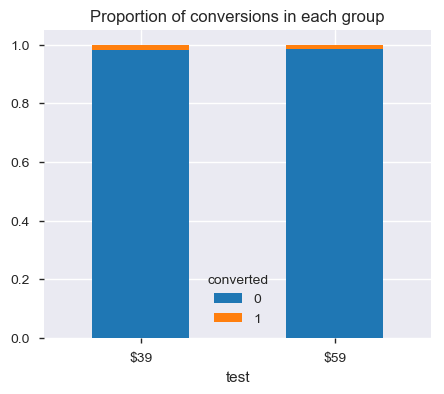

In [18]:
test_results.groupby(["test"])["converted"].value_counts(normalize=True).unstack(
    'converted').plot(kind="bar", stacked=True, figsize=(5,4));
plt.xticks(np.arange(2), ["$39","$59"],rotation=0)
plt.title("Proportion of conversions in each group");

The less expensive software is more likely to sell, but this might not matter when considering the difference in revenue. <br>

In [19]:
How much money would the company make from 1 user at each price?

Object `price` not found.


In [ ]:
How much money would the company make from 1 user at each price

In [20]:
How much money would the company make from 1 user at each price

SyntaxError: invalid syntax (<ipython-input-20-6790e2c1daf3>, line 1)

In [ ]:
# how much money is made? estimated revenue per 1 user
print("Estimated revenue per 1 user made by $39:", 39*.0199) 
print("Estimated revenue per 1 user made by $59:", 59*.0155) 

Are the proportions of converted in each group statistically different?

In [21]:
val_counts = test_results.groupby("test")["converted"].value_counts()
val_counts

test  converted
0     0            198692
      1              4035
1     0            112300
      1              1773
Name: converted, dtype: int64

In [22]:
# This uses a simple normal test for proportions. It should be the
# same as running the mean z-test on the data encoded 
# 1 for event and 0 for no event so that the sum corresponds to the count.

from statsmodels.stats.proportion import proportions_ztest

count = np.array([val_counts[0,1],val_counts[1,1]])
nobs = np.array([val_counts[0,0]+val_counts[0,1],val_counts[1,0]+val_counts[1,1]])
value = .05
stat, pval = proportions_ztest(count, nobs, value)
print("pvalue is", pval)
print("statistically significant")

pvalue is 0.0
statistically significant


There is a significant difference in conversion rates found via a z-test.

The drop in conversion is not significant enough to continue with the lower priced software. More money will be made selling the higher priced software, even though the conversion rate is lower. I suggest the company implement the higher priced software to increase revenue.

## Q2: What attributes of customer behavior influence conversion rate?

In [23]:
# merge user table with results tables
# left merge because there are extra users in the test_results table
merged_df = pd.merge(test_results, user_table, on="user_id", how="left")

In [24]:
merged_df.describe(include="all")

,user_id,timestamp,source,device,operative_system,test,converted,city,country,lat,long
count,316800.000000,316466,316800,316800,296461,316800.000000,316800.000000,275616,275616,275616.000000,275616.000000
unique,NaN,141147,13,2,4,NaN,NaN,923,1,NaN,NaN
top,NaN,2015-04-12 11:51:16,direct_traffic,mobile,windows,NaN,NaN,New York,USA,NaN,NaN
freq,NaN,12,60307,186471,100976,NaN,NaN,25748,275616,NaN,NaN
mean,499281.341840,NaN,NaN,NaN,NaN,0.360079,0.018333,NaN,NaN,37.111680,-93.981772
std,288591.154044,NaN,NaN,NaN,NaN,0.480024,0.134154,NaN,NaN,5.209627,18.086486
min,3.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,19.700000,-157.800000
25%,249525.750000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,33.660000,-112.200000
50%,499021.500000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,37.740000,-88.930000
75%,749025.500000,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,40.700000,-78.910000


In [25]:
# just select meaningful columns for analysis
cols = ["user_id", "timestamp", "source", "device", "operative_system", "test", "converted", "city"]
merged_df = merged_df[cols]

In [26]:
merged_df.head()

,user_id,timestamp,source,device,operative_system,test,converted,city
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,0,Buffalo
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,0,Lakeville
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,0,Parma
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,0,Fayetteville
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,0,Fishers


What was the conversion rate for each source?

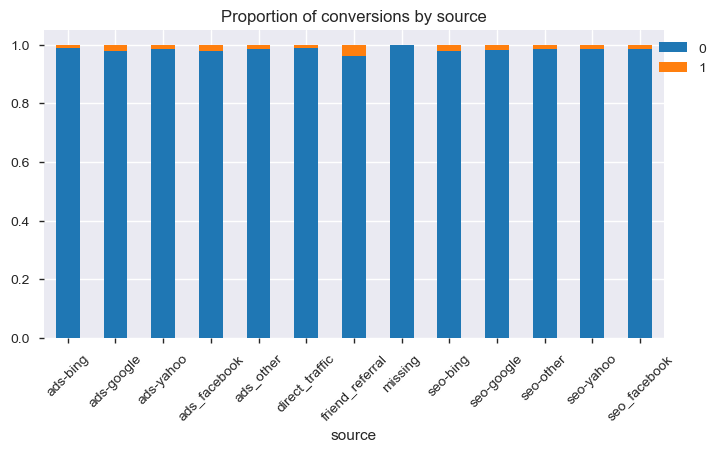

In [27]:
merged_df.groupby(["source"])["converted"].value_counts(normalize=True).sort_values(ascending=False).unstack('converted').plot(kind='bar', stacked=True, figsize=(8,4));
plt.legend(loc='upper center', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=45)
plt.title("Proportion of conversions by source");

In [28]:
src = merged_df.groupby(["source"])["converted"].value_counts(normalize=True).sort_values(ascending=False)

In [29]:
# display conversion rate for each source
print("Ads-bing conversion rate is:", round(src["ads-bing",1]*100,2))
print("Ads-google conversion rate is:", round(src["ads-google",1]*100,2))
print("Ads-yahoo conversion rate is:", round(src["ads-yahoo",1]*100,2))
print("Ads-facebook conversion rate is:", round(src["ads_facebook",1]*100,2))
print("Ads-other conversion rate is:", round(src["ads_other",1]*100,2))
print("Direct traffic conversion rate is:", round(src["direct_traffic",1]*100,2))
print("Friend referral conversion rate is:", round(src["friend_referral",1]*100,2))
print("Seo-bing conversion rate is:", round(src["seo-bing",1]*100,2))
print("Seo-google conversion rate is:", round(src["seo-google",1]*100,2))
print("Seo-other conversion rate is:", round(src["seo-other",1]*100,2))
print("Seo-yahoo conversion rate is:", round(src["seo-yahoo",1]*100,2))
print("Seo-facebook conversion rate is:", round(src["seo_facebook",1]*100,2))
print("Missing conversion rate is:", round(src["missing",1]*100,2))

Ads-bing conversion rate is: 1.2
Ads-google conversion rate is: 2.15
Ads-yahoo conversion rate is: 1.48
Ads-facebook conversion rate is: 2.12
Ads-other conversion rate is: 1.44
Direct traffic conversion rate is: 1.23
Friend referral conversion rate is: 3.87
Seo-bing conversion rate is: 2.37
Seo-google conversion rate is: 1.7
Seo-other conversion rate is: 1.57
Seo-yahoo conversion rate is: 1.62
Seo-facebook conversion rate is: 1.6
Missing conversion rate is: 0.32


The top three highest conversion rates are: 1) Friend Referral, 2) Seo-bing, 3) Ads-google

For each device, what proportion bought the software? This is the conversion rate/device.

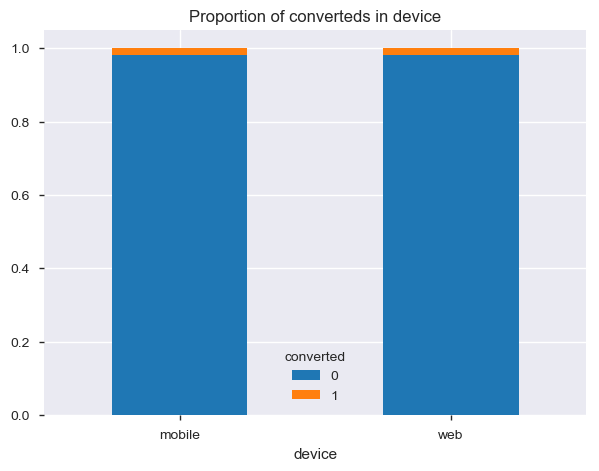

In [30]:
merged_df.groupby(["device"])["converted"].value_counts(normalize=True).unstack('converted').plot(kind='bar', stacked=True, figsize=(7,5));
plt.xticks(rotation=0);
plt.title("Proportion of converteds in device");

Conversion rates are roughly equal between devices.

What kinds of operating systems are users using? Does the conversion rate differ depending on the OS?

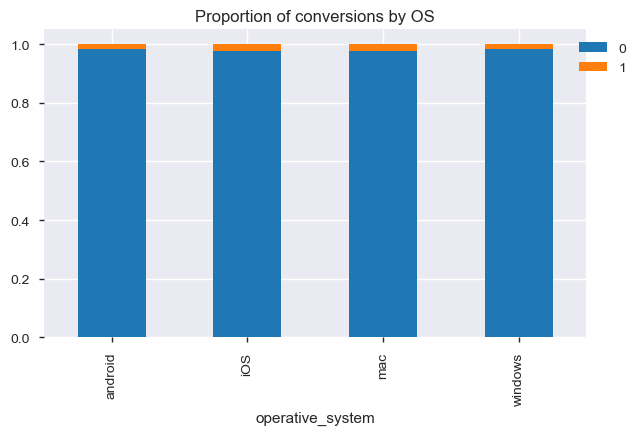

In [31]:
merged_df.groupby(["operative_system"])["converted"].value_counts(normalize=True).unstack('converted').plot(kind='bar', stacked=True, figsize=(7,4));
plt.title("Proportion of conversions by OS")
plt.legend(loc='upper center', bbox_to_anchor=(1.03, 1));

In [32]:
os_ = merged_df.groupby(["operative_system"])["converted"].value_counts(normalize=True)

In [33]:
# display conversion rate for each device
print("Android conversion rate is:", round(os_["android",1]*100,2))
print("iOS conversion rate is:", round(os_["iOS",1]*100,2))
print("Mac conversion rate is:", round(os_["mac",1]*100,2))
print("Windows conversion rate is:", round(os_["windows",1]*100,2))

Android conversion rate is: 1.49
iOS conversion rate is: 2.23
Mac conversion rate is: 2.4
Windows conversion rate is: 1.7


iOS and mac are quite a bit higher, why? Could target windows and android users more.

### Q3: How long should the test have been run for to achieve statistically significant results?

This likely depends on how many users were visiting the site each day - power analysis, sample size estimation. <br>
First calculate the sample size needed:

In [38]:
import statsmodels.stats.api as sms

# effect size for a test comparing two proportions
es = sms.proportion_effectsize(0.0155, 0.0199)

# solve for sample size parameter of the power of a two sample z-test
sample_ = sms.NormalIndPower().solve_power(es, power=0.8, alpha=0.05, ratio=1)
print("Need a sample size per group of:", round(sample_,0))
print("Need total user sample of:", round(sample_,0)*2)

Need a sample size per group of: 14044.0
Need total user sample of: 28088.0


Now calculate the number of users per day to estimate the total number of days needed

In [48]:
# change to datetime
merged_df["timestamp"] = pd.to_datetime(merged_df.timestamp,format="%Y-%m-%d %H:%M:%S",errors='coerce')

In [57]:
# now calculate users per days
t = merged_df.set_index("timestamp")
users_per_day = t.resample("D").user_id.count().mean()
print("Average users per day:", round(users_per_day,2))

Average users per day: 3361.59


In [58]:
print("Total time needed for experiment is:", round(sample_/users_per_day,2), "days")

Total time needed for experiment is: 4.18 days


The total time needed for the experiment is 5 days, but I would recommend longer 2 weeks due to variations in user activity based on day of the week.